#Assignment 3:
##Objective : 
###Apply Brute force KNN and KDTree on BoW,TFIDF,AVGW2V and Weighted TFIDF.
### Get the conclusion table.

In [1]:
import warnings
warnings.filterwarnings("ignore")
import sqlite3
import numpy as np
import pandas as pd
import nltk
import string
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from collections import Counter
from sklearn.metrics import accuracy_score
from sklearn import model_selection
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import classification_report,confusion_matrix
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle
from tqdm import tqdm
import os

import sqlite3
from google.colab import drive 
drive.mount('/content/drive/')


Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


# Data Preprocessing

In [0]:
os.chdir("/content/drive/My Drive/Colab Notebooks")


In [0]:
con = sqlite3.connect("final.sqlite")

In [0]:
import pandas as pd
filtered_data = pd.read_sql_query("""
SELECT * FROM REVIEWS
""",con)

In [5]:
filtered_data.shape

(364171, 12)

In [0]:
filtered_data.set_index = filtered_data.index

In [0]:
filtered_data.drop(['index'],axis=1)
#dropping index value from columns

In [0]:
final_data = filtered_data.sample(100000,random_state=2)

#sampling 100k datapoints

In [0]:
final_data.head(3)
final_data = final_data.sort_values('Time')

In [10]:

final_data.Score.value_counts()


1    84541
0    15459
Name: Score, dtype: int64

In [0]:
final_data_kd_tree  = final_data.sample(20000,random_state=2)
#sampling 20 k points for kd_tree

In [15]:
final_data_kd_tree.Score.value_counts()

1    16917
0     3083
Name: Score, dtype: int64

# KNN on BoW using KD_Tree

In [0]:


count_vect = CountVectorizer(ngram_range=(1,2))
X = final_data_kd_tree['CleanedText'].values

X_tr, X_test = model_selection.train_test_split(X, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
#X_tr, X_cv= model_selection.train_test_split(X_1, test_size=0.3, random_state=0)
final_counts = count_vect.fit_transform(X_tr)

In [24]:
print("the shape of out text BOW vectorizer ",final_counts.shape)
print("the number of unique words are ", final_counts.get_shape()[1])


the shape of out text BOW vectorizer  (14000, 305221)
the number of unique words are  305221


In [25]:
#using truncated svd for dimensionality reduction

from sklearn.decomposition import TruncatedSVD
svd = TruncatedSVD(n_components=300)
svd_data=svd.fit_transform(final_counts)
svd_data.shape

(14000, 300)

Taking 300 dimensions for KD_TREE.
Tried to plot (Explained Variance, No. of features retained), but it gives error for numpy.
Says no attribute for explained_variance_.

In [0]:
y = final_data_kd_tree['Score'].values

y_tr, y_test = model_selection.train_test_split(y, test_size=0.3, random_state=0)


In [0]:
#for CV and test data 
final_counts_test = count_vect.transform(X_test)
svd_data_test=svd.transform(final_counts_test)


In [30]:
svd_data_test.shape

(6000, 300)

Performing 2 cross validation.
Finding the optimal k as follows.
Using 'f1' score for accuracy.


The optimal number of neighbors is 29.


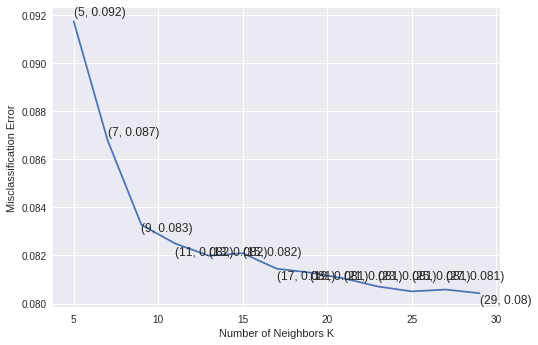

the misclassification error for each k value is :  [0.092 0.087 0.083 0.082 0.082 0.082 0.081 0.081 0.081 0.081 0.081 0.081
 0.08 ]


In [35]:

# creating odd list of K for KNN
myList = list(range(5,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 2-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, svd_data, y_tr, cv=2, scoring='f1')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
      
    


In [36]:
#Performing KNN using kd_tree
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(svd_data,y_tr)
pred = knn.predict(svd_data_test)
acc = f1_score(y_test, pred) * float(100)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 29 is 91.655267%


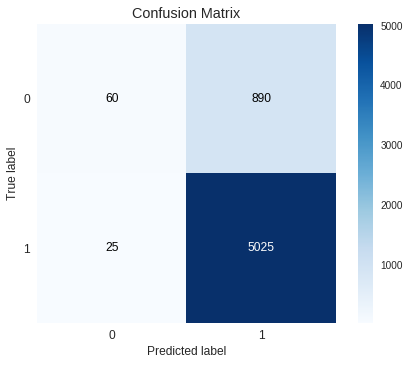

In [51]:
import scikitplot as skplt
skplt.metrics.plot_confusion_matrix(y_test ,pred)


In [52]:
print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

           0       0.71      0.06      0.12       950
           1       0.85      1.00      0.92      5050

   micro avg       0.85      0.85      0.85      6000
   macro avg       0.78      0.53      0.52      6000
weighted avg       0.83      0.85      0.79      6000



# KNN using Brute Force on BoW

In [0]:
#Performing KNN using Brute Force
# split the data set into train and test


X = final_data['CleanedText'].values
y = final_data.Score.values
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
count_vect = CountVectorizer(ngram_range=(1,2))
X_tr = count_vect.fit_transform(X_tr)
X_test = count_vect.transform(X_test)




The optimal number of neighbors is 11.


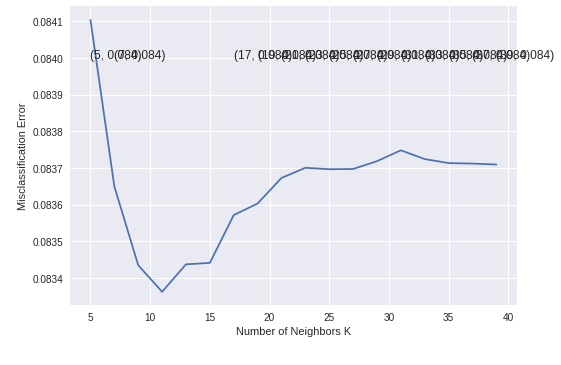

the misclassification error for each k value is :  [0.084 0.084 0.083 0.083 0.083 0.083 0.084 0.084 0.084 0.084 0.084 0.084
 0.084 0.084 0.084 0.084 0.084 0.084]


In [58]:

#Getting the optimal k

# creating odd list of K for KNN using Brute Force
myList = list(range(5,40))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 2-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_tr, y_tr, cv=2, scoring='f1')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))

In [59]:
#Performing KNN using bruteforce
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = f1_score(y_test, pred) * float(100)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 11 is 91.663802%


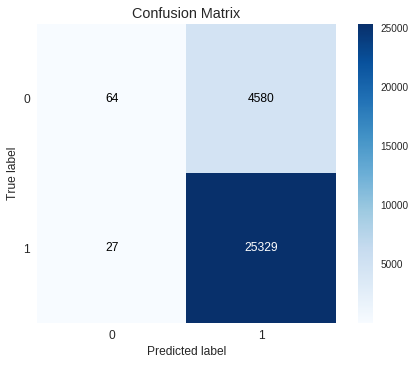

In [61]:
skplt.metrics.plot_confusion_matrix(y_test ,pred)

In [62]:
print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

           0       0.70      0.01      0.03      4644
           1       0.85      1.00      0.92     25356

   micro avg       0.85      0.85      0.85     30000
   macro avg       0.78      0.51      0.47     30000
weighted avg       0.82      0.85      0.78     30000



# Knn on TFIDF using KD_tree

In [63]:
X = final_data_kd_tree['CleanedText'].values
y = final_data_kd_tree.Score.values
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

X_tr = tf_idf_vect.fit_transform(X_tr)
X_test = tf_idf_vect.transform(X_test)


print("the type of count vectorizer ",type(X_tr))
print("the shape of out text TFIDF vectorizer ",X_tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_tr.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (14000, 305221)
the number of unique words including both unigrams and bigrams  305221


In [64]:
#using truncated svd for dimensionality reduction
svd = TruncatedSVD(n_components=300)
X_tr=svd.fit_transform(X_tr)
X_test = svd.transform(X_test)
X_tr.shape


(14000, 300)


The optimal number of neighbors is 23.


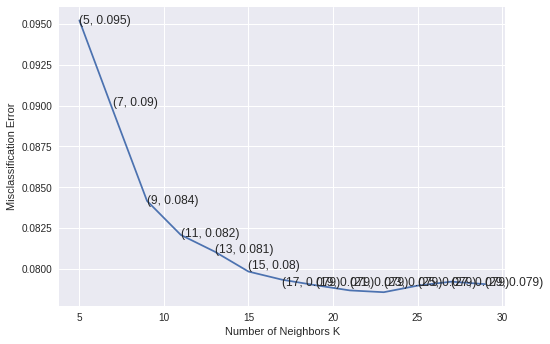

the misclassification error for each k value is :  [0.095 0.09  0.084 0.082 0.081 0.08  0.079 0.079 0.079 0.079 0.079 0.079
 0.079]


In [65]:
#Finding optimal k
# creating odd list of K for KNN
myList = list(range(5,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 2-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k,algorithm='kd_tree')
    scores = cross_val_score(knn, X_tr, y_tr, cv=2, scoring='f1')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
      
    

In [66]:
#Performing KNN using kd_tree
knn = KNeighborsClassifier(n_neighbors=optimal_k,algorithm='kd_tree')
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = f1_score(y_test, pred) * float(100)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 23 is 91.877008%


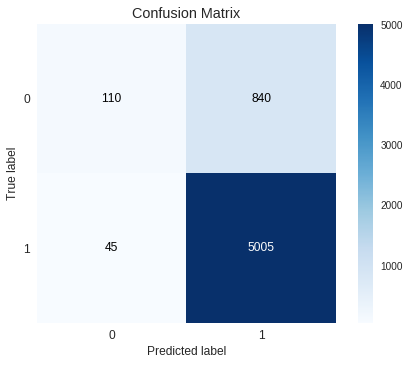

In [68]:
skplt.metrics.plot_confusion_matrix(y_test ,pred)

In [69]:
print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

           0       0.71      0.12      0.20       950
           1       0.86      0.99      0.92      5050

   micro avg       0.85      0.85      0.85      6000
   macro avg       0.78      0.55      0.56      6000
weighted avg       0.83      0.85      0.80      6000



# Knn on TFIDF Using Bruteforce

In [70]:
X = final_data['CleanedText'].values
y = final_data.Score.values
X_tr, X_test, y_tr, y_test = model_selection.train_test_split(X, y, test_size=0.3, random_state=0)
# split the train data set into cross validation train and cross validation test
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))

X_tr = tf_idf_vect.fit_transform(X_tr)
X_test = tf_idf_vect.transform(X_test)
print("the type of count vectorizer ",type(X_tr))
print("the shape of out text TFIDF vectorizer ",X_tr.get_shape())
print("the number of unique words including both unigrams and bigrams ", X_tr.get_shape()[1])


the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (70000, 993591)
the number of unique words including both unigrams and bigrams  993591



The optimal number of neighbors is 9.


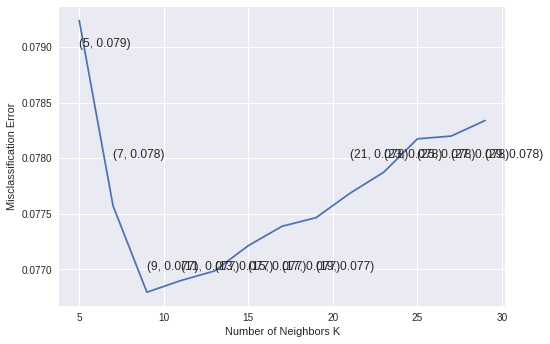

the misclassification error for each k value is :  [0.079 0.078 0.077 0.077 0.077 0.077 0.077 0.077 0.078 0.078 0.078 0.078
 0.078]


In [71]:
#Finding optimal k

# creating odd list of K for KNN
myList = list(range(5,30))
neighbors = list(filter(lambda x: x % 2 != 0, myList))

# empty list that will hold cv scores
cv_scores = []

# perform 2-fold cross validation
for k in neighbors:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_tr, y_tr, cv=2, scoring='f1')
    cv_scores.append(scores.mean())

# changing to misclassification error
MSE = [1 - x for x in cv_scores]

# determining best k
optimal_k = neighbors[MSE.index(min(MSE))]
print('\nThe optimal number of neighbors is %d.' % optimal_k)

# plot misclassification error vs k 
plt.plot(neighbors, MSE)

for xy in zip(neighbors, np.round(MSE,3)):
    plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

plt.xlabel('Number of Neighbors K')
plt.ylabel('Misclassification Error')
plt.show()

print("the misclassification error for each k value is : ", np.round(MSE,3))
      
    

In [72]:
#Performing KNN using bruteforce
knn = KNeighborsClassifier(n_neighbors=optimal_k)
knn.fit(X_tr,y_tr)
pred = knn.predict(X_test)
acc = f1_score(y_test, pred) * float(100)
print('\nThe accuracy of the knn classifier for k = %d is %f%%' % (optimal_k, acc))


The accuracy of the knn classifier for k = 9 is 92.252721%


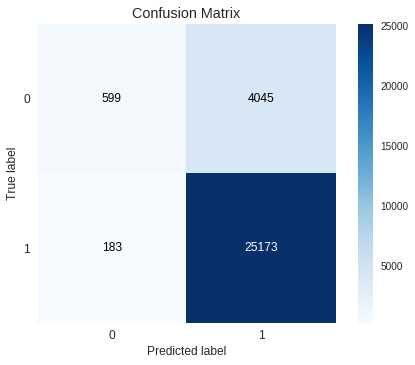

In [73]:
skplt.metrics.plot_confusion_matrix(y_test ,pred)

In [74]:
print(classification_report(y_test ,pred))

              precision    recall  f1-score   support

           0       0.77      0.13      0.22      4644
           1       0.86      0.99      0.92     25356

   micro avg       0.86      0.86      0.86     30000
   macro avg       0.81      0.56      0.57     30000
weighted avg       0.85      0.86      0.81     30000

